<a href="https://colab.research.google.com/github/BrutFab/ppo_BipedalWalker_v3/blob/main/ppo_BipedalWalker_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup**


### **Install Packages**

In [ ]:
!apt install swig cmake ffmpeg xvfb python3-opengl
!pip install stable-baselines3==2.0.0a5 gymnasium[box2d] huggingface_sb3 pyvirtualdisplay imageio[ffmpeg]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 swig4.0 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  libgle3 python3-numpy swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 python3-opengl swig swig4.0
  x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 14 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,755 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://

The Next Cell will force the notebook runtime to restart. This is to ensure all the new libraries installed will be used.

In [ ]:
import os
os.kill(os.getpid(), 9)

### **Setup Environment**

In [ ]:
import gymnasium as gym
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

In [ ]:
class FastWalkerEnv(gym.Wrapper):
    def __init__(self, env, max_steps=1600, switch_threshold=800):
        super().__init__(env)
        self.max_steps = max_steps  # Max steps per episode
        self.steps = 0
        self.start_pos = None
        self.last_pos = None
        self.switch_threshold = switch_threshold  # After how many steps to switch logic
        self.use_custom_logic = False  # Flag to switch to custom logic

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.steps = 0
        self.start_pos = self.env.unwrapped.hull.position[0]  # Initial position
        self.last_pos = self.start_pos
        self.use_custom_logic = False  # Start with default logic
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        self.steps += 1

        current_pos = self.env.unwrapped.hull.position[0]
        distance = current_pos - self.start_pos

        # After switch_threshold steps, start using custom logic
        if self.steps >= self.switch_threshold:
            self.use_custom_logic = True

        if self.use_custom_logic:
            # 1. Custom Reward Logic (based on distance and velocity)
            velocity = self.env.unwrapped.hull.linearVelocity.x  # Horizontal speed
            distance_reward = distance * 0.25  # Reward for distance
            velocity_reward = velocity * 0.5  # Reward for speed

            # Combining rewards
            modified_reward = distance_reward + velocity_reward + reward
            reward = modified_reward

            # 2. Custom logic for stuck condition
            if abs(current_pos - self.last_pos) < 0.01 :
                terminated = True

            # 3. Apply custom max steps logic
            if self.steps >= self.max_steps:
                truncated = True

        # Otherwise, use the default logic (before threshold)
        else:
            pass

        info['distance'] = distance
        self.last_pos = current_pos

        return obs, reward, terminated, truncated, info

In [ ]:
def make_env():
    env = gym.make('BipedalWalker-v3', hardcore=False, render_mode="rgb_array")
    env = FastWalkerEnv(env, max_steps=1600) # Custom Env
    return Monitor(env)

In [ ]:
SEED = 42  # Ensures reproducibility across parallel environments

env_train = make_vec_env(
    make_env,   # Environment creation function
    n_envs=4,   # Number of parallel environments
    seed=SEED
)

### **Observation Space**
Observation Space Shape (24,) vector of size 24, where each value contains different information about the walker:

- **Hull Angle Speed**: The speed at which the main body of the walker is rotating.
- **Angular Velocity**: The rate of change of the angular position of the walker.
- **Horizontal Speed**: The speed at which the walker is moving horizontally.
- **Vertical Speed**: The speed at which the walker is moving vertically.
- **Position of Joints**: The positions (angles) of the walker's joints. Given that the walker has 4 joints, this take up 4 values.
- **Joints Angular Speed**: The rate of change of the angular position for each joint. Again, this would be 4 values for the 4 joints.
- **Legs Contact with Ground**: Indicating whether each leg is in contact with the ground. Given two legs, this contains 2 values.
- **10 Lidar Rangefinder Measurements**: These are distance measurements to detect obstacles or terrain features around the walker. There are 10 of these values.


In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env_train.observation_space.shape)
print("Sample observation", env_train.observation_space.sample()) # Take a random observation

_____OBSERVATION SPACE_____ 

Observation Space Shape (24,)
Sample observation [ 0.2006335   1.5893735  -1.3399588   3.3080277   0.3055347  -2.7162728
 -1.9315122   2.8864806   3.947239   -0.5277454   4.8524895   2.4722133
 -2.8191514   0.32722342 -0.71175134  0.8383089  -0.9938027  -0.63582444
  0.6287187  -0.3576082  -0.80304885 -0.67655563  0.96649766  0.4879449 ]


### **Action Space**

 Actions are motor speed values in the [-1, 1] range for each of the 4 joints at both hips and knees.

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env_train.action_space.shape)
print("Action Space Sample", env_train.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape (4,)
Action Space Sample [ 0.5479121  -0.12224312  0.71719587  0.39473605]


# **2. Building the Model**

In [ ]:
from stable_baselines3 import A2C

In [ ]:
model = A2C(
    policy="MlpPolicy",  # Neural network type (MLP).
    env=env_train,       # Training environment.
    gamma=0.99,          # Discount factor for rewards.
    n_steps=35,          # Steps per update.
    vf_coef=0.1,         # Value function loss weight.
    ent_coef=0.01,       # Entropy loss weight (exploration).
    max_grad_norm=0.5,   # Gradient clipping threshold.
    learning_rate=5e-4,  # Learning rate for optimization.
    verbose=0            # Verbosity level (0 = silent).
)

# **3. Video Generation**

In [ ]:
import os
import numpy as np
from wasabi import Printer
from stable_baselines3.common.base_class import BaseAlgorithm
from pathlib import Path
import tempfile
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    VecEnv,
    VecVideoRecorder,
)

In [ ]:
msg = Printer()

In [ ]:
def generate_replay(
    model: BaseAlgorithm,
    eval_env: VecEnv,
    video_length: int,
    is_deterministic: bool,
    local_path: Path,
):
    with tempfile.TemporaryDirectory() as tmpdirname:
        # Set up VecVideoRecorder
        env = VecVideoRecorder(
            eval_env,
            tmpdirname,
            record_video_trigger=lambda x: x == 0,
            video_length=video_length,
            name_prefix="",
        )

        # Adjust handling of reset() return values
        try:
            obs, info = env.reset()
        except ValueError:
            obs = env.reset()
            info = {}

        lstm_states = None
        episode_starts = np.ones((env.num_envs,), dtype=bool)

        try:
            # Run for at most 1600 steps or video_length, whichever is smaller
            max_steps = min(1600, video_length)
            for step in range(max_steps):
                action, lstm_states = model.predict(
                    obs,
                    state=lstm_states,
                    episode_start=episode_starts,
                    deterministic=is_deterministic,
                )
                try:
                    obs, rewards, terminated, truncated, info = env.step(action)
                except ValueError:
                    obs, rewards, done, info = env.step(action)
                    terminated = done
                    truncated = False

                episode_starts = terminated if isinstance(terminated, np.ndarray) else np.array([terminated])

                # Stop video recording if agent falls or gets stuck
                if any(terminated):
                    break

            env.close()

            # Convert video to x264 codec
            inp = env.video_recorder.path
            out = local_path
            os.system(f"ffmpeg -y -i {inp} -vcodec h264 {out}")
            print(f"Video saved to: {out}")

        except KeyboardInterrupt:
            pass
        except Exception as e:
            msg.fail(str(e))
            msg.fail("We are unable to generate a replay of your agent")

# **4. Training**

In [ ]:
model_name = "a2c-FastWalker-v3"

episodes = 2_000_000
save_freq = 5_000

# Initialization
distances = []
best_distance = -float("inf")
best_model = None

for episode in range(0, episodes, save_freq):
    # Training the model
    model.learn(total_timesteps=save_freq)

    # Testing the model in a new environment
    eval_env = make_env() # Create a new independent environment for testing
    obs, info = eval_env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True) # Predict the next action deterministically
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated

    final_distance = info['distance']
    distances.append(final_distance)
    print(f"Episode {episode + save_freq}: Distance traveled = {final_distance:.2f}")

    # Save video every 100,000 episodes to monitor training progress
    if (episode) % 100_000 == 0 or final_distance > 80:
        video_path = f"replay_ep{episode + save_freq}_dist{final_distance:.2f}.mp4"
        generate_replay(
              model=model,
              eval_env=DummyVecEnv([make_env]),
              video_length=1600,
              is_deterministic=True, # Use deterministic actions for reproducibility
              local_path=video_path # Save the video to the specified path
        )
        print()
        print(f"Video updated and saved as: {video_path}")
        print()

    # Check if this episode achieved the best distance so far
    if final_distance > best_distance:
        best_distance = final_distance
        best_model = model
        print(f"New best model, distance: {best_distance:.2f}")
        print()
        # Wait a bit before saving the best to avoid unnecessary saves
        best_video_path = f"best_replay_ep{episode + save_freq}_dist{final_distance:.2f}.mp4"
        generate_replay(
            model=best_model,
            eval_env=DummyVecEnv([make_env]),
            video_length=1600,
            is_deterministic=True, # Use deterministic actions for reproducibility
            local_path=best_video_path) # Save the video to the specified path

        print()
        print(f"Best video updated and saved as: {best_video_path}")
        print()

Episode 5000: Distance traveled = -1.39
Moviepy - Building video /tmp/tmpjvq4_mb7/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpjvq4_mb7/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpjvq4_mb7/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpjvq4_mb7/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpjvq4_mb7/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpjvq4_mb7/-step-0-to-step-1600.mp4
Video saved to: replay_ep5000_dist-1.39.mp4

Video updated and saved as: replay_ep5000_dist-1.39.mp4

New best model, distance: -1.39

Moviepy - Building video /tmp/tmpgk1qyg8p/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpgk1qyg8p/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpgk1qyg8p/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpgk1qyg8p/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpgk1qyg8p/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpgk1qyg8p/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep5000_dist-1.39.mp4

Best video updated and saved as: best_replay_ep5000_dist-1.39.mp4

Episode 10000: Distance traveled = -1.67
Episode 15000: Distance traveled = -1.57
Episode 20000: Distance traveled = -1.58
Episode 25000: Distance traveled = 2.13
New best model, distance: 2.13

Moviepy - Building video /tmp/tmp706yprzc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp706yprzc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp706yprzc/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp706yprzc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp706yprzc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp706yprzc/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep25000_dist2.13.mp4

Best video updated and saved as: best_replay_ep25000_dist2.13.mp4

Episode 30000: Distance traveled = -2.27
Episode 35000: Distance traveled = 1.76
Episode 40000: Distance traveled = 2.33
New best model, distance: 2.33

Moviepy - Building video /tmp/tmp5xsj3sbl/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp5xsj3sbl/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp5xsj3sbl/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp5xsj3sbl/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp5xsj3sbl/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp5xsj3sbl/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep40000_dist2.33.mp4

Best video updated and saved as: best_replay_ep40000_dist2.33.mp4

Episode 45000: Distance traveled = 0.45
Episode 50000: Distance traveled = -0.13
Episode 55000: Distance traveled = 2.40
New best model, distance: 2.40

Moviepy - Building video /tmp/tmp9ejdvs0c/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9ejdvs0c/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9ejdvs0c/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp9ejdvs0c/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9ejdvs0c/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9ejdvs0c/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep55000_dist2.40.mp4

Best video updated and saved as: best_replay_ep55000_dist2.40.mp4

Episode 60000: Distance traveled = -1.00
Episode 65000: Distance traveled = 2.19
Episode 70000: Distance traveled = 2.40
New best model, distance: 2.40

Moviepy - Building video /tmp/tmp7c9qkgbj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp7c9qkgbj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp7c9qkgbj/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp7c9qkgbj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp7c9qkgbj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp7c9qkgbj/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep70000_dist2.40.mp4

Best video updated and saved as: best_replay_ep70000_dist2.40.mp4

Episode 75000: Distance traveled = -2.31
Episode 80000: Distance traveled = -1.89
Episode 85000: Distance traveled = 0.04
Episode 90000: Distance traveled = -2.29
Episode 95000: Distance traveled = -0.76
Episode 100000: Distance traveled = -3.24
Episode 105000: Distance traveled = 2.39
Moviepy - Building video /tmp/tmpfh782dqh/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpfh782dqh/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpfh782dqh/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpfh782dqh/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpfh782dqh/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpfh782dqh/-step-0-to-step-1600.mp4
Video saved to: replay_ep105000_dist2.39.mp4

Video updated and saved as: replay_ep105000_dist2.39.mp4

Episode 110000: Distance traveled = 2.19
Episode 115000: Distance traveled = -0.69
Episode 120000: Distance traveled = -0.60
Episode 125000: Distance traveled = -2.31
Episode 130000: Distance traveled = -0.42
Episode 135000: Distance traveled = 1.20
Episode 140000: Distance traveled = -2.20
Episode 145000: Distance traveled = -0.73
Episode 150000: Distance traveled = 2.90
New best model, distance: 2.90

Moviepy - Building video /tmp/tmpc6hvyb98/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpc6hvyb98/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpc6hvyb98/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpc6hvyb98/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpc6hvyb98/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpc6hvyb98/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep150000_dist2.90.mp4

Best video updated and saved as: best_replay_ep150000_dist2.90.mp4

Episode 155000: Distance traveled = 3.05
New best model, distance: 3.05

Moviepy - Building video /tmp/tmp9hjajof9/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9hjajof9/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9hjajof9/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp9hjajof9/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9hjajof9/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9hjajof9/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep155000_dist3.05.mp4

Best video updated and saved as: best_replay_ep155000_dist3.05.mp4

Episode 160000: Distance traveled = 0.56
Episode 165000: Distance traveled = 0.70
Episode 170000: Distance traveled = -0.32
Episode 175000: Distance traveled = -0.34
Episode 180000: Distance traveled = -0.32
Episode 185000: Distance traveled = -0.74
Episode 190000: Distance traveled = 0.83
Episode 195000: Distance traveled = -0.18
Episode 200000: Distance traveled = -1.60
Episode 205000: Distance traveled = -0.34
Moviepy - Building video /tmp/tmprn_nlxxm/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmprn_nlxxm/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmprn_nlxxm/-step-0-to-step-1600.mp4


Saving video to /tmp/tmprn_nlxxm/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmprn_nlxxm/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmprn_nlxxm/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmprn_nlxxm/-step-0-to-step-1600.mp4
Video saved to: replay_ep205000_dist-0.34.mp4

Video updated and saved as: replay_ep205000_dist-0.34.mp4

Episode 210000: Distance traveled = 1.87
Episode 215000: Distance traveled = -0.15
Episode 220000: Distance traveled = 1.21
Episode 225000: Distance traveled = -0.03
Episode 230000: Distance traveled = -0.06
Episode 235000: Distance traveled = -0.27
Episode 240000: Distance traveled = -0.43
Episode 245000: Distance traveled = -0.14
Episode 250000: Distance traveled = 0.40
Episode 255000: Distance traveled = -0.32
Episode 260000: Distance traveled = -1.07
Episode 265000: Distance traveled = -1.37
Episode 270000: Distance traveled = -0.91
Episode 275000: Distance traveled = -0.76
Episode 280000: Distance traveled = -0.17
Episode 285000: Distance traveled = -0.84
Episode 290000: Distance traveled = 2.37
Episode 295000: Distance traveled = -0.11
Episode 300000: Distance traveled = 1.60
Episode 305000: Dist

Moviepy - Done !
Moviepy - video ready /tmp/tmpfwrzs_x7/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpfwrzs_x7/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpfwrzs_x7/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpfwrzs_x7/-step-0-to-step-1600.mp4
Video saved to: replay_ep305000_dist1.98.mp4

Video updated and saved as: replay_ep305000_dist1.98.mp4

Episode 310000: Distance traveled = 1.45
Episode 315000: Distance traveled = 1.89
Episode 320000: Distance traveled = 2.13
Episode 325000: Distance traveled = 1.95
Episode 330000: Distance traveled = 4.95
New best model, distance: 4.95

Moviepy - Building video /tmp/tmpuuwavlc0/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpuuwavlc0/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpuuwavlc0/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpuuwavlc0/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpuuwavlc0/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpuuwavlc0/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep330000_dist4.95.mp4

Best video updated and saved as: best_replay_ep330000_dist4.95.mp4

Episode 335000: Distance traveled = 4.95
Episode 340000: Distance traveled = -0.53
Episode 345000: Distance traveled = 1.25
Episode 350000: Distance traveled = 1.78
Episode 355000: Distance traveled = 20.48
New best model, distance: 20.48

Moviepy - Building video /tmp/tmpqgai45br/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpqgai45br/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpqgai45br/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpqgai45br/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpqgai45br/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpqgai45br/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep355000_dist20.48.mp4

Best video updated and saved as: best_replay_ep355000_dist20.48.mp4

Episode 360000: Distance traveled = 1.84
Episode 365000: Distance traveled = 13.56
Episode 370000: Distance traveled = -1.75
Episode 375000: Distance traveled = 8.86
Episode 380000: Distance traveled = 20.55
New best model, distance: 20.55

Moviepy - Building video /tmp/tmpvwhau5c0/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpvwhau5c0/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpvwhau5c0/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpvwhau5c0/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpvwhau5c0/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpvwhau5c0/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep380000_dist20.55.mp4

Best video updated and saved as: best_replay_ep380000_dist20.55.mp4

Episode 385000: Distance traveled = 28.74
New best model, distance: 28.74

Moviepy - Building video /tmp/tmpn035izze/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpn035izze/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpn035izze/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpn035izze/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpn035izze/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpn035izze/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep385000_dist28.74.mp4

Best video updated and saved as: best_replay_ep385000_dist28.74.mp4

Episode 390000: Distance traveled = 29.21
New best model, distance: 29.21

Moviepy - Building video /tmp/tmpd1e8waiv/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpd1e8waiv/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpd1e8waiv/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpd1e8waiv/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpd1e8waiv/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpd1e8waiv/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep390000_dist29.21.mp4

Best video updated and saved as: best_replay_ep390000_dist29.21.mp4

Episode 395000: Distance traveled = -4.69
Episode 400000: Distance traveled = 24.91
Episode 405000: Distance traveled = 33.78
Moviepy - Building video /tmp/tmpqaeaojn9/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpqaeaojn9/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpqaeaojn9/-step-0-to-step-1600.mp4


Saving video to /tmp/tmpqaeaojn9/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmpqaeaojn9/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpqaeaojn9/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpqaeaojn9/-step-0-to-step-1600.mp4
Video saved to: replay_ep405000_dist33.78.mp4

Video updated and saved as: replay_ep405000_dist33.78.mp4

New best model, distance: 33.78

Moviepy - Building video /tmp/tmp03wi7nez/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp03wi7nez/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp03wi7nez/-step-0-to-step-1600.mp4


Saving video to /tmp/tmp03wi7nez/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmp03wi7nez/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp03wi7nez/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp03wi7nez/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep405000_dist33.78.mp4

Best video updated and saved as: best_replay_ep405000_dist33.78.mp4

Episode 410000: Distance traveled = 25.47
Episode 415000: Distance traveled = 34.06
New best model, distance: 34.06

Moviepy - Building video /tmp/tmplf7n35q6/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmplf7n35q6/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmplf7n35q6/-step-0-to-step-1600.mp4


Saving video to /tmp/tmplf7n35q6/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmplf7n35q6/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmplf7n35q6/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmplf7n35q6/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep415000_dist34.06.mp4

Best video updated and saved as: best_replay_ep415000_dist34.06.mp4

Episode 420000: Distance traveled = 4.49
Episode 425000: Distance traveled = 42.67
New best model, distance: 42.67

Moviepy - Building video /tmp/tmpo060rb1e/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpo060rb1e/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpo060rb1e/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpo060rb1e/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpo060rb1e/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpo060rb1e/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep425000_dist42.67.mp4

Best video updated and saved as: best_replay_ep425000_dist42.67.mp4

Episode 430000: Distance traveled = 67.27
New best model, distance: 67.27

Moviepy - Building video /tmp/tmpo2k62jkh/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpo2k62jkh/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpo2k62jkh/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpo2k62jkh/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpo2k62jkh/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpo2k62jkh/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep430000_dist67.27.mp4

Best video updated and saved as: best_replay_ep430000_dist67.27.mp4

Episode 435000: Distance traveled = 12.37
Episode 440000: Distance traveled = 3.88
Episode 445000: Distance traveled = 43.64
Episode 450000: Distance traveled = 1.81
Episode 455000: Distance traveled = 1.62
Episode 460000: Distance traveled = 1.50
Episode 465000: Distance traveled = 1.60
Episode 470000: Distance traveled = 1.63
Episode 475000: Distance traveled = 2.40
Episode 480000: Distance traveled = 1.93
Episode 485000: Distance traveled = 4.88
Episode 490000: Distance traveled = 6.92
Episode 495000: Distance traveled = 5.56
Episode 500000: Distance traveled = 0.81
Episode 505000: Distance traveled = 0.30
Moviepy - Building video /tmp/tmpub3ljfzb/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpub3ljfzb/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpub3ljfzb/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpub3ljfzb/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpub3ljfzb/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpub3ljfzb/-step-0-to-step-1600.mp4
Video saved to: replay_ep505000_dist0.30.mp4

Video updated and saved as: replay_ep505000_dist0.30.mp4

Episode 510000: Distance traveled = 1.02
Episode 515000: Distance traveled = 1.66
Episode 520000: Distance traveled = 5.84
Episode 525000: Distance traveled = 6.03
Episode 530000: Distance traveled = 3.22
Episode 535000: Distance traveled = 10.00
Episode 540000: Distance traveled = 26.93
Episode 545000: Distance traveled = 8.57
Episode 550000: Distance traveled = 7.12
Episode 555000: Distance traveled = 5.87
Episode 560000: Distance traveled = 5.14
Episode 565000: Distance traveled = 5.56
Episode 570000: Distance traveled = 6.58
Episode 575000: Distance traveled = -0.01
Episode 580000: Distance traveled = 3.16
Episode 585000: Distance traveled = 4.85
Episode 590000: Distance traveled = 8.97
Episode 595000: Distance traveled = 9.15
Episode 600000: Distance traveled = 8.05
Episode 605000: Distance traveled

Moviepy - Done !
Moviepy - video ready /tmp/tmpgx2tobdv/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpgx2tobdv/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpgx2tobdv/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpgx2tobdv/-step-0-to-step-1600.mp4
Video saved to: replay_ep605000_dist7.52.mp4

Video updated and saved as: replay_ep605000_dist7.52.mp4

Episode 610000: Distance traveled = 8.50
Episode 615000: Distance traveled = 21.00
Episode 620000: Distance traveled = 3.13
Episode 625000: Distance traveled = 1.21
Episode 630000: Distance traveled = 3.71
Episode 635000: Distance traveled = 8.30
Episode 640000: Distance traveled = 13.28
Episode 645000: Distance traveled = 34.14
Episode 650000: Distance traveled = 18.60
Episode 655000: Distance traveled = 3.46
Episode 660000: Distance traveled = 2.58
Episode 665000: Distance traveled = 9.89
Episode 670000: Distance traveled = 6.24
Episode 675000: Distance traveled = 16.37
Episode 680000: Distance traveled = 2.53
Episode 685000: Distance traveled = 1.44
Episode 690000: Distance traveled = 2.67
Episode 695000: Distance traveled = 7.80
Episode 700000: Distance traveled = 21.07
Episode 705000: Distance trave

Moviepy - Done !
Moviepy - video ready /tmp/tmpx54i_i8m/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpx54i_i8m/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpx54i_i8m/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpx54i_i8m/-step-0-to-step-1600.mp4
Video saved to: replay_ep705000_dist1.91.mp4

Video updated and saved as: replay_ep705000_dist1.91.mp4

Episode 710000: Distance traveled = 3.43
Episode 715000: Distance traveled = 3.41
Episode 720000: Distance traveled = 2.40
Episode 725000: Distance traveled = 2.90
Episode 730000: Distance traveled = 4.16
Episode 735000: Distance traveled = 3.36
Episode 740000: Distance traveled = 11.24
Episode 745000: Distance traveled = 3.16
Episode 750000: Distance traveled = 3.79
Episode 755000: Distance traveled = 10.77
Episode 760000: Distance traveled = 3.25
Episode 765000: Distance traveled = 3.50
Episode 770000: Distance traveled = 2.44
Episode 775000: Distance traveled = 8.16
Episode 780000: Distance traveled = 1.67
Episode 785000: Distance traveled = -0.71
Episode 790000: Distance traveled = 2.60
Episode 795000: Distance traveled = 9.34
Episode 800000: Distance traveled = 1.19
Episode 805000: Distance traveled

Moviepy - Done !
Moviepy - video ready /tmp/tmp8agtuy5_/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp8agtuy5_/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp8agtuy5_/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp8agtuy5_/-step-0-to-step-1600.mp4
Video saved to: replay_ep805000_dist17.24.mp4

Video updated and saved as: replay_ep805000_dist17.24.mp4

Episode 810000: Distance traveled = 11.45
Episode 815000: Distance traveled = 30.16
Episode 820000: Distance traveled = 41.75
Episode 825000: Distance traveled = 2.24
Episode 830000: Distance traveled = 11.28
Episode 835000: Distance traveled = 16.26
Episode 840000: Distance traveled = 6.68
Episode 845000: Distance traveled = 28.80
Episode 850000: Distance traveled = 84.05
Moviepy - Building video /tmp/tmpngk3niud/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpngk3niud/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpngk3niud/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpngk3niud/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpngk3niud/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpngk3niud/-step-0-to-step-1600.mp4
Video saved to: replay_ep850000_dist84.05.mp4

Video updated and saved as: replay_ep850000_dist84.05.mp4

New best model, distance: 84.05

Moviepy - Building video /tmp/tmp_roqd5me/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp_roqd5me/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp_roqd5me/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp_roqd5me/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp_roqd5me/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp_roqd5me/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep850000_dist84.05.mp4

Best video updated and saved as: best_replay_ep850000_dist84.05.mp4

Episode 855000: Distance traveled = 32.77
Episode 860000: Distance traveled = 6.18
Episode 865000: Distance traveled = 44.27
Episode 870000: Distance traveled = 39.84
Episode 875000: Distance traveled = 27.41
Episode 880000: Distance traveled = 6.61
Episode 885000: Distance traveled = 5.82
Episode 890000: Distance traveled = 40.95
Episode 895000: Distance traveled = 30.57
Episode 900000: Distance traveled = 0.38
Episode 905000: Distance traveled = 79.23
Moviepy - Building video /tmp/tmp9b1ui06w/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9b1ui06w/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9b1ui06w/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp9b1ui06w/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9b1ui06w/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9b1ui06w/-step-0-to-step-1600.mp4
Video saved to: replay_ep905000_dist79.23.mp4

Video updated and saved as: replay_ep905000_dist79.23.mp4

Episode 910000: Distance traveled = 21.00
Episode 915000: Distance traveled = 52.81
Episode 920000: Distance traveled = 32.74
Episode 925000: Distance traveled = 4.90
Episode 930000: Distance traveled = 6.35
Episode 935000: Distance traveled = 1.64
Episode 940000: Distance traveled = 1.66
Episode 945000: Distance traveled = 1.70
Episode 950000: Distance traveled = 84.07
Moviepy - Building video /tmp/tmp90lxhf52/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp90lxhf52/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp90lxhf52/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp90lxhf52/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp90lxhf52/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp90lxhf52/-step-0-to-step-1600.mp4
Video saved to: replay_ep950000_dist84.07.mp4

Video updated and saved as: replay_ep950000_dist84.07.mp4

New best model, distance: 84.07

Moviepy - Building video /tmp/tmp30zlt2uc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp30zlt2uc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp30zlt2uc/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp30zlt2uc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp30zlt2uc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp30zlt2uc/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep950000_dist84.07.mp4

Best video updated and saved as: best_replay_ep950000_dist84.07.mp4

Episode 955000: Distance traveled = 10.63
Episode 960000: Distance traveled = 5.84
Episode 965000: Distance traveled = 14.51
Episode 970000: Distance traveled = 51.08
Episode 975000: Distance traveled = 38.64
Episode 980000: Distance traveled = 55.02
Episode 985000: Distance traveled = 52.81
Episode 990000: Distance traveled = 44.02
Episode 995000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmpr_bihg_s/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpr_bihg_s/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpr_bihg_s/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpr_bihg_s/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpr_bihg_s/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpr_bihg_s/-step-0-to-step-1600.mp4
Video saved to: replay_ep995000_dist84.03.mp4

Video updated and saved as: replay_ep995000_dist84.03.mp4

Episode 1000000: Distance traveled = 1.86
Episode 1005000: Distance traveled = 22.83
Moviepy - Building video /tmp/tmpe509zcdj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpe509zcdj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpe509zcdj/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpe509zcdj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpe509zcdj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpe509zcdj/-step-0-to-step-1600.mp4
Video saved to: replay_ep1005000_dist22.83.mp4

Video updated and saved as: replay_ep1005000_dist22.83.mp4

Episode 1010000: Distance traveled = 6.22
Episode 1015000: Distance traveled = 55.15
Episode 1020000: Distance traveled = 23.11
Episode 1025000: Distance traveled = 5.28
Episode 1030000: Distance traveled = 44.52
Episode 1035000: Distance traveled = 38.90
Episode 1040000: Distance traveled = 54.85
Episode 1045000: Distance traveled = 4.71
Episode 1050000: Distance traveled = 42.53
Episode 1055000: Distance traveled = 10.86
Episode 1060000: Distance traveled = 7.09
Episode 1065000: Distance traveled = 9.49
Episode 1070000: Distance traveled = 53.24
Episode 1075000: Distance traveled = 22.42
Episode 1080000: Distance traveled = 84.02
Moviepy - Building video /tmp/tmp7u1r8xpg/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp7u1r8xpg/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp7u1r8xpg/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp7u1r8xpg/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp7u1r8xpg/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp7u1r8xpg/-step-0-to-step-1600.mp4
Video saved to: replay_ep1080000_dist84.02.mp4

Video updated and saved as: replay_ep1080000_dist84.02.mp4

Episode 1085000: Distance traveled = 12.89
Episode 1090000: Distance traveled = 9.33
Episode 1095000: Distance traveled = 10.61
Episode 1100000: Distance traveled = 52.19
Episode 1105000: Distance traveled = 5.62
Moviepy - Building video /tmp/tmpozqsgrar/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpozqsgrar/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpozqsgrar/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpozqsgrar/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpozqsgrar/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpozqsgrar/-step-0-to-step-1600.mp4
Video saved to: replay_ep1105000_dist5.62.mp4

Video updated and saved as: replay_ep1105000_dist5.62.mp4

Episode 1110000: Distance traveled = 15.95
Episode 1115000: Distance traveled = 14.12
Episode 1120000: Distance traveled = 18.32
Episode 1125000: Distance traveled = 2.59
Episode 1130000: Distance traveled = 57.19
Episode 1135000: Distance traveled = 17.51
Episode 1140000: Distance traveled = 7.99
Episode 1145000: Distance traveled = 58.27
Episode 1150000: Distance traveled = 19.81
Episode 1155000: Distance traveled = 79.07
Episode 1160000: Distance traveled = 84.07
Moviepy - Building video /tmp/tmp2rob9jkj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp2rob9jkj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp2rob9jkj/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp2rob9jkj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp2rob9jkj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp2rob9jkj/-step-0-to-step-1600.mp4
Video saved to: replay_ep1160000_dist84.07.mp4

Video updated and saved as: replay_ep1160000_dist84.07.mp4

Episode 1165000: Distance traveled = 84.05
Moviepy - Building video /tmp/tmpppnmts6k/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpppnmts6k/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpppnmts6k/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpppnmts6k/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpppnmts6k/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpppnmts6k/-step-0-to-step-1600.mp4
Video saved to: replay_ep1165000_dist84.05.mp4

Video updated and saved as: replay_ep1165000_dist84.05.mp4

Episode 1170000: Distance traveled = 3.40
Episode 1175000: Distance traveled = 5.84
Episode 1180000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmpztu3f_tv/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpztu3f_tv/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpztu3f_tv/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpztu3f_tv/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpztu3f_tv/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpztu3f_tv/-step-0-to-step-1600.mp4
Video saved to: replay_ep1180000_dist84.03.mp4

Video updated and saved as: replay_ep1180000_dist84.03.mp4

Episode 1185000: Distance traveled = 3.86
Episode 1190000: Distance traveled = 2.19
Episode 1195000: Distance traveled = 2.77
Episode 1200000: Distance traveled = 15.59
Episode 1205000: Distance traveled = 5.74
Moviepy - Building video /tmp/tmpv91126zx/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpv91126zx/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpv91126zx/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpv91126zx/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpv91126zx/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpv91126zx/-step-0-to-step-1600.mp4
Video saved to: replay_ep1205000_dist5.74.mp4

Video updated and saved as: replay_ep1205000_dist5.74.mp4

Episode 1210000: Distance traveled = 31.02
Episode 1215000: Distance traveled = 24.63
Episode 1220000: Distance traveled = 62.16
Episode 1225000: Distance traveled = 5.96
Episode 1230000: Distance traveled = 17.97
Episode 1235000: Distance traveled = 8.78
Episode 1240000: Distance traveled = 43.02
Episode 1245000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmpomjychmi/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpomjychmi/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpomjychmi/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpomjychmi/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpomjychmi/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpomjychmi/-step-0-to-step-1600.mp4
Video saved to: replay_ep1245000_dist84.03.mp4

Video updated and saved as: replay_ep1245000_dist84.03.mp4

Episode 1250000: Distance traveled = 51.80
Episode 1255000: Distance traveled = 5.13
Episode 1260000: Distance traveled = 2.90
Episode 1265000: Distance traveled = 26.11
Episode 1270000: Distance traveled = 84.01
Moviepy - Building video /tmp/tmp31yevhp5/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp31yevhp5/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp31yevhp5/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp31yevhp5/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp31yevhp5/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp31yevhp5/-step-0-to-step-1600.mp4
Video saved to: replay_ep1270000_dist84.01.mp4

Video updated and saved as: replay_ep1270000_dist84.01.mp4

Episode 1275000: Distance traveled = 8.49
Episode 1280000: Distance traveled = 15.89
Episode 1285000: Distance traveled = 84.08
Moviepy - Building video /tmp/tmpa1d7gvmt/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpa1d7gvmt/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpa1d7gvmt/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpa1d7gvmt/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpa1d7gvmt/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpa1d7gvmt/-step-0-to-step-1600.mp4
Video saved to: replay_ep1285000_dist84.08.mp4

Video updated and saved as: replay_ep1285000_dist84.08.mp4

New best model, distance: 84.08

Moviepy - Building video /tmp/tmp00_500qi/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp00_500qi/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp00_500qi/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp00_500qi/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp00_500qi/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp00_500qi/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep1285000_dist84.08.mp4

Best video updated and saved as: best_replay_ep1285000_dist84.08.mp4

Episode 1290000: Distance traveled = 56.70
Episode 1295000: Distance traveled = 17.91
Episode 1300000: Distance traveled = 49.20
Episode 1305000: Distance traveled = 35.18
Moviepy - Building video /tmp/tmpnts7saog/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpnts7saog/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpnts7saog/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpnts7saog/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpnts7saog/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpnts7saog/-step-0-to-step-1600.mp4
Video saved to: replay_ep1305000_dist35.18.mp4

Video updated and saved as: replay_ep1305000_dist35.18.mp4

Episode 1310000: Distance traveled = 37.79
Episode 1315000: Distance traveled = 83.47
Moviepy - Building video /tmp/tmpry2bzlyk/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpry2bzlyk/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpry2bzlyk/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpry2bzlyk/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpry2bzlyk/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpry2bzlyk/-step-0-to-step-1600.mp4
Video saved to: replay_ep1315000_dist83.47.mp4

Video updated and saved as: replay_ep1315000_dist83.47.mp4

Episode 1320000: Distance traveled = 51.54
Episode 1325000: Distance traveled = 14.94
Episode 1330000: Distance traveled = 2.30
Episode 1335000: Distance traveled = 1.48
Episode 1340000: Distance traveled = -0.74
Episode 1345000: Distance traveled = -0.49
Episode 1350000: Distance traveled = 12.26
Episode 1355000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmph9_dkvnr/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmph9_dkvnr/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmph9_dkvnr/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmph9_dkvnr/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmph9_dkvnr/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmph9_dkvnr/-step-0-to-step-1600.mp4
Video saved to: replay_ep1355000_dist84.03.mp4

Video updated and saved as: replay_ep1355000_dist84.03.mp4

Episode 1360000: Distance traveled = 1.08
Episode 1365000: Distance traveled = 1.54
Episode 1370000: Distance traveled = 1.14
Episode 1375000: Distance traveled = 3.97
Episode 1380000: Distance traveled = 25.16
Episode 1385000: Distance traveled = 74.16
Episode 1390000: Distance traveled = 3.87
Episode 1395000: Distance traveled = 10.36
Episode 1400000: Distance traveled = 56.87
Episode 1405000: Distance traveled = 5.44
Moviepy - Building video /tmp/tmpp07i65d7/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpp07i65d7/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpp07i65d7/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpp07i65d7/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpp07i65d7/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpp07i65d7/-step-0-to-step-1600.mp4
Video saved to: replay_ep1405000_dist5.44.mp4

Video updated and saved as: replay_ep1405000_dist5.44.mp4

Episode 1410000: Distance traveled = 2.94
Episode 1415000: Distance traveled = 51.96
Episode 1420000: Distance traveled = 13.74
Episode 1425000: Distance traveled = 3.52
Episode 1430000: Distance traveled = 20.16
Episode 1435000: Distance traveled = 19.21
Episode 1440000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmp3swl5wf6/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3swl5wf6/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3swl5wf6/-step-0-to-step-1600.mp4


Saving video to /tmp/tmp3swl5wf6/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmp3swl5wf6/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3swl5wf6/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3swl5wf6/-step-0-to-step-1600.mp4
Video saved to: replay_ep1440000_dist84.03.mp4

Video updated and saved as: replay_ep1440000_dist84.03.mp4

Episode 1445000: Distance traveled = 27.41
Episode 1450000: Distance traveled = 84.06
Moviepy - Building video /tmp/tmpsugi8vgf/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpsugi8vgf/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpsugi8vgf/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpsugi8vgf/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpsugi8vgf/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpsugi8vgf/-step-0-to-step-1600.mp4
Video saved to: replay_ep1450000_dist84.06.mp4

Video updated and saved as: replay_ep1450000_dist84.06.mp4

Episode 1455000: Distance traveled = 3.58
Episode 1460000: Distance traveled = 38.41
Episode 1465000: Distance traveled = 4.63
Episode 1470000: Distance traveled = 84.08
Moviepy - Building video /tmp/tmp3fjrontj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3fjrontj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3fjrontj/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp3fjrontj/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3fjrontj/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3fjrontj/-step-0-to-step-1600.mp4
Video saved to: replay_ep1470000_dist84.08.mp4

Video updated and saved as: replay_ep1470000_dist84.08.mp4

Episode 1475000: Distance traveled = 84.04
Moviepy - Building video /tmp/tmpefpvxtrs/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpefpvxtrs/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpefpvxtrs/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpefpvxtrs/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpefpvxtrs/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpefpvxtrs/-step-0-to-step-1600.mp4
Video saved to: replay_ep1475000_dist84.04.mp4

Video updated and saved as: replay_ep1475000_dist84.04.mp4

Episode 1480000: Distance traveled = 24.37
Episode 1485000: Distance traveled = 17.06
Episode 1490000: Distance traveled = 84.06
Moviepy - Building video /tmp/tmp04rdxzja/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp04rdxzja/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp04rdxzja/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp04rdxzja/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp04rdxzja/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp04rdxzja/-step-0-to-step-1600.mp4
Video saved to: replay_ep1490000_dist84.06.mp4

Video updated and saved as: replay_ep1490000_dist84.06.mp4

Episode 1495000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmpcciu33wc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpcciu33wc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpcciu33wc/-step-0-to-step-1600.mp4


Saving video to /tmp/tmpcciu33wc/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmpcciu33wc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpcciu33wc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpcciu33wc/-step-0-to-step-1600.mp4
Video saved to: replay_ep1495000_dist84.03.mp4

Video updated and saved as: replay_ep1495000_dist84.03.mp4

Episode 1500000: Distance traveled = 52.89
Episode 1505000: Distance traveled = 64.23
Moviepy - Building video /tmp/tmpeh5wxzbx/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpeh5wxzbx/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpeh5wxzbx/-step-0-to-step-1600.mp4


Saving video to /tmp/tmpeh5wxzbx/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmpeh5wxzbx/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpeh5wxzbx/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpeh5wxzbx/-step-0-to-step-1600.mp4
Video saved to: replay_ep1505000_dist64.23.mp4

Video updated and saved as: replay_ep1505000_dist64.23.mp4

Episode 1510000: Distance traveled = 20.71
Episode 1515000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmpcnet5h_4/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpcnet5h_4/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpcnet5h_4/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpcnet5h_4/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpcnet5h_4/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpcnet5h_4/-step-0-to-step-1600.mp4
Video saved to: replay_ep1515000_dist84.03.mp4

Video updated and saved as: replay_ep1515000_dist84.03.mp4

Episode 1520000: Distance traveled = 17.51
Episode 1525000: Distance traveled = 11.93
Episode 1530000: Distance traveled = 7.64
Episode 1535000: Distance traveled = 13.66
Episode 1540000: Distance traveled = 13.09
Episode 1545000: Distance traveled = 84.06
Moviepy - Building video /tmp/tmpy9osks7y/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpy9osks7y/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpy9osks7y/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpy9osks7y/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpy9osks7y/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpy9osks7y/-step-0-to-step-1600.mp4
Video saved to: replay_ep1545000_dist84.06.mp4

Video updated and saved as: replay_ep1545000_dist84.06.mp4

Episode 1550000: Distance traveled = 30.37
Episode 1555000: Distance traveled = 6.37
Episode 1560000: Distance traveled = 17.22
Episode 1565000: Distance traveled = 16.99
Episode 1570000: Distance traveled = 3.85
Episode 1575000: Distance traveled = 14.49
Episode 1580000: Distance traveled = 6.02
Episode 1585000: Distance traveled = 17.89
Episode 1590000: Distance traveled = 84.05
Moviepy - Building video /tmp/tmpwyxktyex/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpwyxktyex/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpwyxktyex/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpwyxktyex/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpwyxktyex/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpwyxktyex/-step-0-to-step-1600.mp4
Video saved to: replay_ep1590000_dist84.05.mp4

Video updated and saved as: replay_ep1590000_dist84.05.mp4

Episode 1595000: Distance traveled = 31.87
Episode 1600000: Distance traveled = 51.39
Episode 1605000: Distance traveled = 84.05
Moviepy - Building video /tmp/tmp3yi65lne/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3yi65lne/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3yi65lne/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp3yi65lne/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3yi65lne/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3yi65lne/-step-0-to-step-1600.mp4
Video saved to: replay_ep1605000_dist84.05.mp4

Video updated and saved as: replay_ep1605000_dist84.05.mp4

Episode 1610000: Distance traveled = 84.09
Moviepy - Building video /tmp/tmpspm9en9x/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpspm9en9x/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpspm9en9x/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpspm9en9x/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpspm9en9x/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpspm9en9x/-step-0-to-step-1600.mp4
Video saved to: replay_ep1610000_dist84.09.mp4

Video updated and saved as: replay_ep1610000_dist84.09.mp4

New best model, distance: 84.09

Moviepy - Building video /tmp/tmpzzkq0mtr/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpzzkq0mtr/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzzkq0mtr/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpzzkq0mtr/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpzzkq0mtr/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzzkq0mtr/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep1610000_dist84.09.mp4

Best video updated and saved as: best_replay_ep1610000_dist84.09.mp4

Episode 1615000: Distance traveled = 23.24
Episode 1620000: Distance traveled = 37.05
Episode 1625000: Distance traveled = 14.02
Episode 1630000: Distance traveled = 0.34
Episode 1635000: Distance traveled = 0.58
Episode 1640000: Distance traveled = 5.65
Episode 1645000: Distance traveled = 3.02
Episode 1650000: Distance traveled = 35.07
Episode 1655000: Distance traveled = 8.33
Episode 1660000: Distance traveled = 21.12
Episode 1665000: Distance traveled = 41.07
Episode 1670000: Distance traveled = 7.01
Episode 1675000: Distance traveled = 5.90
Episode 1680000: Distance traveled = 5.95
Episode 1685000: Distance traveled = 7.51
Episode 1690000: Distance traveled = 84.06
Moviepy - Building video /tmp/tmp0py_act1/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp0py_act1/-step-0-

Moviepy - Done !
Moviepy - video ready /tmp/tmp0py_act1/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp0py_act1/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp0py_act1/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp0py_act1/-step-0-to-step-1600.mp4
Video saved to: replay_ep1690000_dist84.06.mp4

Video updated and saved as: replay_ep1690000_dist84.06.mp4

Episode 1695000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmp95czd94c/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp95czd94c/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp95czd94c/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp95czd94c/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp95czd94c/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp95czd94c/-step-0-to-step-1600.mp4
Video saved to: replay_ep1695000_dist84.03.mp4

Video updated and saved as: replay_ep1695000_dist84.03.mp4

Episode 1700000: Distance traveled = 84.07
Moviepy - Building video /tmp/tmpnergfze7/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpnergfze7/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpnergfze7/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpnergfze7/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpnergfze7/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpnergfze7/-step-0-to-step-1600.mp4
Video saved to: replay_ep1700000_dist84.07.mp4

Video updated and saved as: replay_ep1700000_dist84.07.mp4

Episode 1705000: Distance traveled = 18.37
Moviepy - Building video /tmp/tmp2nnvjcum/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp2nnvjcum/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp2nnvjcum/-step-0-to-step-1600.mp4


Saving video to /tmp/tmp2nnvjcum/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmp2nnvjcum/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp2nnvjcum/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp2nnvjcum/-step-0-to-step-1600.mp4
Video saved to: replay_ep1705000_dist18.37.mp4

Video updated and saved as: replay_ep1705000_dist18.37.mp4

Episode 1710000: Distance traveled = 44.25
Episode 1715000: Distance traveled = 60.73
Episode 1720000: Distance traveled = 21.80
Episode 1725000: Distance traveled = 84.10
Moviepy - Building video /tmp/tmphpe2d539/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmphpe2d539/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmphpe2d539/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmphpe2d539/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmphpe2d539/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmphpe2d539/-step-0-to-step-1600.mp4
Video saved to: replay_ep1725000_dist84.10.mp4

Video updated and saved as: replay_ep1725000_dist84.10.mp4

New best model, distance: 84.10

Moviepy - Building video /tmp/tmpfh5h5jqc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpfh5h5jqc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpfh5h5jqc/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpfh5h5jqc/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpfh5h5jqc/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpfh5h5jqc/-step-0-to-step-1600.mp4
Video saved to: best_replay_ep1725000_dist84.10.mp4

Best video updated and saved as: best_replay_ep1725000_dist84.10.mp4

Episode 1730000: Distance traveled = 84.01
Moviepy - Building video /tmp/tmp0bxxk_xv/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp0bxxk_xv/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp0bxxk_xv/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp0bxxk_xv/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp0bxxk_xv/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp0bxxk_xv/-step-0-to-step-1600.mp4
Video saved to: replay_ep1730000_dist84.01.mp4

Video updated and saved as: replay_ep1730000_dist84.01.mp4

Episode 1735000: Distance traveled = 84.06
Moviepy - Building video /tmp/tmpezht120s/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpezht120s/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpezht120s/-step-0-to-step-1600.mp4


Saving video to /tmp/tmpezht120s/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmpezht120s/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpezht120s/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpezht120s/-step-0-to-step-1600.mp4
Video saved to: replay_ep1735000_dist84.06.mp4

Video updated and saved as: replay_ep1735000_dist84.06.mp4

Episode 1740000: Distance traveled = 84.02
Moviepy - Building video /tmp/tmpzvx5xlpi/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpzvx5xlpi/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzvx5xlpi/-step-0-to-step-1600.mp4


Saving video to /tmp/tmpzvx5xlpi/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmpzvx5xlpi/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpzvx5xlpi/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzvx5xlpi/-step-0-to-step-1600.mp4
Video saved to: replay_ep1740000_dist84.02.mp4

Video updated and saved as: replay_ep1740000_dist84.02.mp4

Episode 1745000: Distance traveled = 7.21
Episode 1750000: Distance traveled = 50.39
Episode 1755000: Distance traveled = 22.21
Episode 1760000: Distance traveled = 40.94
Episode 1765000: Distance traveled = 3.95
Episode 1770000: Distance traveled = 20.38
Episode 1775000: Distance traveled = 25.18
Episode 1780000: Distance traveled = 9.38
Episode 1785000: Distance traveled = 21.25
Episode 1790000: Distance traveled = 0.90
Episode 1795000: Distance traveled = 84.01
Moviepy - Building video /tmp/tmpd13r0ane/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpd13r0ane/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpd13r0ane/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpd13r0ane/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpd13r0ane/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpd13r0ane/-step-0-to-step-1600.mp4
Video saved to: replay_ep1795000_dist84.01.mp4

Video updated and saved as: replay_ep1795000_dist84.01.mp4

Episode 1800000: Distance traveled = 84.02
Moviepy - Building video /tmp/tmp6vp3ke11/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp6vp3ke11/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp6vp3ke11/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp6vp3ke11/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp6vp3ke11/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp6vp3ke11/-step-0-to-step-1600.mp4
Video saved to: replay_ep1800000_dist84.02.mp4

Video updated and saved as: replay_ep1800000_dist84.02.mp4

Episode 1805000: Distance traveled = 50.05
Moviepy - Building video /tmp/tmp9yr6d85_/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9yr6d85_/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9yr6d85_/-step-0-to-step-1600.mp4


Saving video to /tmp/tmp9yr6d85_/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmp9yr6d85_/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9yr6d85_/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9yr6d85_/-step-0-to-step-1600.mp4
Video saved to: replay_ep1805000_dist50.05.mp4

Video updated and saved as: replay_ep1805000_dist50.05.mp4

Episode 1810000: Distance traveled = 20.35
Episode 1815000: Distance traveled = 74.28
Episode 1820000: Distance traveled = 3.71
Episode 1825000: Distance traveled = 84.06
Moviepy - Building video /tmp/tmpakbi57hw/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpakbi57hw/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpakbi57hw/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpakbi57hw/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpakbi57hw/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpakbi57hw/-step-0-to-step-1600.mp4
Video saved to: replay_ep1825000_dist84.06.mp4

Video updated and saved as: replay_ep1825000_dist84.06.mp4

Episode 1830000: Distance traveled = 2.53
Episode 1835000: Distance traveled = 0.74
Episode 1840000: Distance traveled = 1.33
Episode 1845000: Distance traveled = 1.15
Episode 1850000: Distance traveled = 84.03
Moviepy - Building video /tmp/tmplz0v_c90/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmplz0v_c90/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmplz0v_c90/-step-0-to-step-1600.mp4


Saving video to /tmp/tmplz0v_c90/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmplz0v_c90/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmplz0v_c90/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmplz0v_c90/-step-0-to-step-1600.mp4
Video saved to: replay_ep1850000_dist84.03.mp4

Video updated and saved as: replay_ep1850000_dist84.03.mp4

Episode 1855000: Distance traveled = 1.39
Episode 1860000: Distance traveled = 1.94
Episode 1865000: Distance traveled = 1.48
Episode 1870000: Distance traveled = 2.54
Episode 1875000: Distance traveled = 84.05
Moviepy - Building video /tmp/tmpb8pkx91i/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpb8pkx91i/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpb8pkx91i/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpb8pkx91i/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpb8pkx91i/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpb8pkx91i/-step-0-to-step-1600.mp4
Video saved to: replay_ep1875000_dist84.05.mp4

Video updated and saved as: replay_ep1875000_dist84.05.mp4

Episode 1880000: Distance traveled = 3.15
Episode 1885000: Distance traveled = 5.77
Episode 1890000: Distance traveled = 72.05
Episode 1895000: Distance traveled = 84.06
Moviepy - Building video /tmp/tmp1henecow/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp1henecow/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp1henecow/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp1henecow/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp1henecow/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp1henecow/-step-0-to-step-1600.mp4
Video saved to: replay_ep1895000_dist84.06.mp4

Video updated and saved as: replay_ep1895000_dist84.06.mp4

Episode 1900000: Distance traveled = 84.01
Moviepy - Building video /tmp/tmp_b1ddg_s/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp_b1ddg_s/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp_b1ddg_s/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp_b1ddg_s/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp_b1ddg_s/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp_b1ddg_s/-step-0-to-step-1600.mp4
Video saved to: replay_ep1900000_dist84.01.mp4

Video updated and saved as: replay_ep1900000_dist84.01.mp4

Episode 1905000: Distance traveled = 84.01
Moviepy - Building video /tmp/tmpzhndaki_/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpzhndaki_/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzhndaki_/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmpzhndaki_/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpzhndaki_/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpzhndaki_/-step-0-to-step-1600.mp4
Video saved to: replay_ep1905000_dist84.01.mp4

Video updated and saved as: replay_ep1905000_dist84.01.mp4

Episode 1910000: Distance traveled = 84.04
Moviepy - Building video /tmp/tmpy92v3tgt/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpy92v3tgt/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpy92v3tgt/-step-0-to-step-1600.mp4


Saving video to /tmp/tmpy92v3tgt/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmpy92v3tgt/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmpy92v3tgt/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpy92v3tgt/-step-0-to-step-1600.mp4
Video saved to: replay_ep1910000_dist84.04.mp4

Video updated and saved as: replay_ep1910000_dist84.04.mp4

Episode 1915000: Distance traveled = 18.04
Episode 1920000: Distance traveled = 11.37
Episode 1925000: Distance traveled = 22.83
Episode 1930000: Distance traveled = 44.17
Episode 1935000: Distance traveled = 46.90
Episode 1940000: Distance traveled = 84.04
Moviepy - Building video /tmp/tmp9f8oduvp/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9f8oduvp/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9f8oduvp/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp9f8oduvp/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp9f8oduvp/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp9f8oduvp/-step-0-to-step-1600.mp4
Video saved to: replay_ep1940000_dist84.04.mp4

Video updated and saved as: replay_ep1940000_dist84.04.mp4

Episode 1945000: Distance traveled = 25.18
Episode 1950000: Distance traveled = 12.77
Episode 1955000: Distance traveled = 84.05
Moviepy - Building video /tmp/tmp1j6p7_d9/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp1j6p7_d9/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp1j6p7_d9/-step-0-to-step-1600.mp4


Saving video to /tmp/tmp1j6p7_d9/-step-0-to-step-1600.mp4
Moviepy - Building video /tmp/tmp1j6p7_d9/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp1j6p7_d9/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp1j6p7_d9/-step-0-to-step-1600.mp4
Video saved to: replay_ep1955000_dist84.05.mp4

Video updated and saved as: replay_ep1955000_dist84.05.mp4

Episode 1960000: Distance traveled = 11.47
Episode 1965000: Distance traveled = 21.96
Episode 1970000: Distance traveled = 57.37
Episode 1975000: Distance traveled = 84.09
Moviepy - Building video /tmp/tmp3un1ea68/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3un1ea68/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3un1ea68/-step-0-to-step-1600.mp4


Moviepy - Building video /tmp/tmp3un1ea68/-step-0-to-step-1600.mp4.
Moviepy - Writing video /tmp/tmp3un1ea68/-step-0-to-step-1600.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp3un1ea68/-step-0-to-step-1600.mp4
Video saved to: replay_ep1975000_dist84.09.mp4

Video updated and saved as: replay_ep1975000_dist84.09.mp4

Episode 1980000: Distance traveled = 54.20
Episode 1985000: Distance traveled = 5.60
Episode 1990000: Distance traveled = 44.00
Episode 1995000: Distance traveled = 5.19
Episode 2000000: Distance traveled = 3.29


### **Save best Model**

In [ ]:
best_model.save(model_name)
print(f"Best model saved as: {model_name}")

Best model saved as: a2c-FastWalker-v3


### **Statisitiques**

In [ ]:
import numpy as np
print(f"Final statistics: Mean: {np.mean(distances):.2f}, Max: {np.max(distances):.2f}")

Statistiques finales: Moyenne: 21.68, Max: 84.10


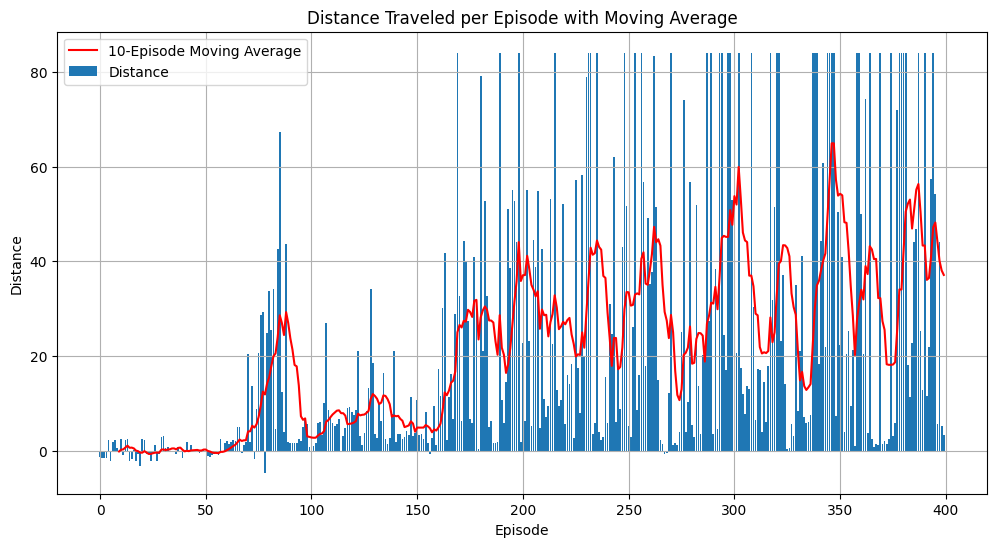

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

lst_dist = np.round(distances, 2)

# Calculate the moving average using pandas
window_size = 10
moving_average = pd.Series(lst_dist).rolling(window=window_size).mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Display distances as bars
plt.bar(range(len(lst_dist)), lst_dist, label='Distance')

# Plot the moving average
plt.plot(range(window_size - 1, len(lst_dist)), moving_average[window_size - 1:], color='red', label=f'{window_size}-Episode Moving Average')

# Show plot details
plt.xlabel('Episode')
plt.ylabel('Distance')
plt.title('Distance Traveled per Episode with Moving Average')
plt.legend()
plt.grid(True)
plt.show()